In [2]:
pip install opencv-python


Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 38.6/38.6 MB 1.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import itertools

import cv2
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import missingno as msno
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import iplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping, LearningRateScheduler
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7


In [5]:
data_dir = 'F:\mango'
ds_name = 'mango'

In [6]:

# Etiketlerle birlikte veri yollarını oluştur
def generate_data_paths(data_dir):
    
    filepaths = []
    labels = []
    
    #Dosya isimlerini  alır ve bir diziye atar
    folds = os.listdir(data_dir)
    #for döngüsü, veri kümesindeki klasörleri ve bu klasörlerdeki dosyaları gezerek,
    #her dosyanın tam yolunu (filepaths) ve sınıf etiketini (labels) toplar. 
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
            
            
    return filepaths, labels

# Veri kümesindeki dosya yollarını ve etiketleri toplar.
filepaths, labels = generate_data_paths(data_dir)

In [7]:
def create_df(filepaths, labels):

    Fseries = pd.Series(filepaths, name= 'filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis= 1)
    
    return df

df = create_df(filepaths, labels)

In [8]:
df

filepaths       labels
0     F:\mango\Anthracnose\20211008_124249 (Custom).jpg  Anthracnose
1     F:\mango\Anthracnose\20211008_124250 (Custom).jpg  Anthracnose
2     F:\mango\Anthracnose\20211008_124252 (Custom).jpg  Anthracnose
3     F:\mango\Anthracnose\20211008_124253 (Custom).jpg  Anthracnose
4     F:\mango\Anthracnose\20211008_124256 (Custom).jpg  Anthracnose
...                                                 ...          ...
3995  F:\mango\Sooty Mould\IMG_20211212_150412 (Cust...  Sooty Mould
3996  F:\mango\Sooty Mould\IMG_20211212_150421 (Cust...  Sooty Mould
3997  F:\mango\Sooty Mould\IMG_20211212_150513 (Cust...  Sooty Mould
3998  F:\mango\Sooty Mould\IMG_20211212_150516 (Cust...  Sooty Mould
3999  F:\mango\Sooty Mould\IMG_20211212_150519 (Cust...  Sooty Mould

[4000 rows x 2 columns]

In [9]:
def num_of_examples(df, name='df'):
    print(f"{name} veri seti {df.shape[0]} adet görsele sahip.")
    
num_of_examples(df, ds_name)

mango veri seti 4000 adet görsele sahip.


In [10]:
#Bu fonksiyon, bir veri çerçevesinde bulunan sınıf sayısını hesaplar.
def num_of_classes(df, name='df'):
    print(f"{name} veri setinde {len(df['labels'].unique())} sınıf vardır.")
    
num_of_classes(df, ds_name)

mango veri setinde 8 sınıf vardır.


In [11]:
def classes_count(df, name='df'):
    
    print(f"{name} veri setinde: ")
    print("="*70)
    print()
    for name in df['labels'].unique():
        num_class = len(df['labels'][df['labels'] == name])
        print(f"'{name}'sınıfı {num_class} adet görsele sahip. ")
        print('-'*70)
        
classes_count(df, ds_name)

mango veri setinde: 

'Anthracnose'sınıfı 500 adet görsele sahip. 
----------------------------------------------------------------------
'Bacterial Canker'sınıfı 500 adet görsele sahip. 
----------------------------------------------------------------------
'Cutting Weevil'sınıfı 500 adet görsele sahip. 
----------------------------------------------------------------------
'Die Back'sınıfı 500 adet görsele sahip. 
----------------------------------------------------------------------
'Gall Midge'sınıfı 500 adet görsele sahip. 
----------------------------------------------------------------------
'Healthy'sınıfı 500 adet görsele sahip. 
----------------------------------------------------------------------
'Powdery Mildew'sınıfı 500 adet görsele sahip. 
----------------------------------------------------------------------
'Sooty Mould'sınıfı 500 adet görsele sahip. 
----------------------------------------------------------------------


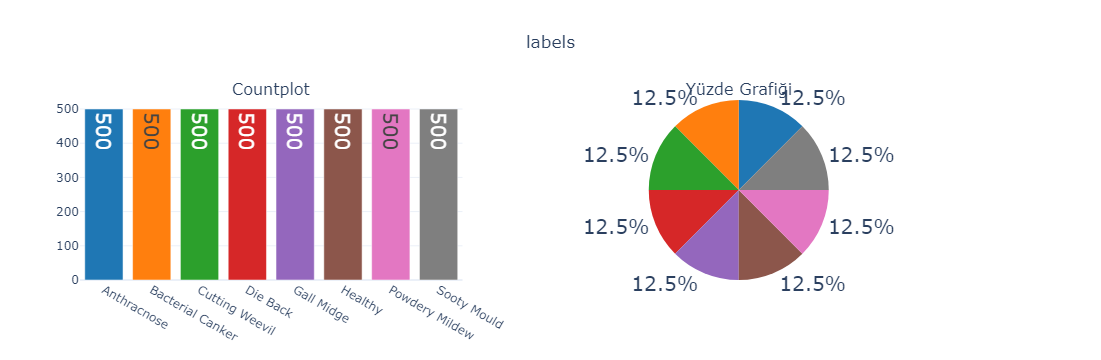

In [12]:
def cat_summary_with_graph(dataframe, col_name):
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=('Countplot', 'Yüzde Grafiği'),
                        specs=[[{"type": "bar"}, {'type': 'pie'}]])

    fig.add_trace(go.Bar(y=dataframe[col_name].value_counts().values.tolist(),
                         x=[str(i) for i in dataframe[col_name].value_counts().index],
                         text=dataframe[col_name].value_counts().values.tolist(),
                         textfont=dict(size=20),
                         name=col_name,
                         textposition='auto',
                         showlegend=False,
                         marker=dict(color=colors)),
                  row=1, col=1)

    fig.add_trace(go.Pie(labels=dataframe[col_name].value_counts().keys(),
                         values=dataframe[col_name].value_counts().values,
                         textfont=dict(size=20),
                         textposition='auto',
                         showlegend=False,
                         name=col_name,
                         marker=dict(colors=colors)),
                  row=1, col=2)

    fig.update_layout(title={'text': col_name,
                             'y': 0.9,
                             'x': 0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      template='plotly_white')

    iplot(fig)
    
    
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
              '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

cat_summary_with_graph(df,'labels')

In [13]:
def check_null_values(df, name='df'):
    
    num_null_vals = sum(df.isnull().sum().values)
    
    if not num_null_vals:
        print(f"{name} veri kümesinde boş(null) değer yok.")
    
    else:
        print(f"The {name} veri kümesinde {num_null_vals} null değerleri vardır.")
        print('-'*70)
        print('Her sütundaki toplam null değerleri:\n')
        print(df.isnull().sum())

In [14]:
#import ettiğimiz scitik-learn kütüphanesine ait train_test_split fonksiyonu ile veri setini
# bölebiliriz.

# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.7, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123)

In [15]:
#Bu fonksiyon, bir DataFrame'deki görüntü sayısını yazdırmak için kullanılır.
def num_imgs(df, name='df'):
    print(f"{name} kümesinde {len(df)} görsel.")


In [16]:
num_imgs(train_df, 'Training ')
num_imgs(valid_df, 'Validation ')
num_imgs(test_df, 'Testing ')

Training  kümesinde 2800 görsel.
Validation  kümesinde 600 görsel.
Testing  kümesinde 600 görsel.


In [17]:
num_of_classes(train_df, "Training ")
num_of_classes(valid_df, "Validation ")
num_of_classes(test_df, "Testing ")

Training  veri setinde 8 sınıf vardır.
Validation  veri setinde 8 sınıf vardır.
Testing  veri setinde 8 sınıf vardır.


In [18]:
classes_count(train_df, 'Training '+ds_name)

Training mango veri setinde: 

'Die Back'sınıfı 354 adet görsele sahip. 
----------------------------------------------------------------------
'Powdery Mildew'sınıfı 353 adet görsele sahip. 
----------------------------------------------------------------------
'Cutting Weevil'sınıfı 348 adet görsele sahip. 
----------------------------------------------------------------------
'Anthracnose'sınıfı 365 adet görsele sahip. 
----------------------------------------------------------------------
'Gall Midge'sınıfı 365 adet görsele sahip. 
----------------------------------------------------------------------
'Sooty Mould'sınıfı 343 adet görsele sahip. 
----------------------------------------------------------------------
'Bacterial Canker'sınıfı 322 adet görsele sahip. 
----------------------------------------------------------------------
'Healthy'sınıfı 350 adet görsele sahip. 
----------------------------------------------------------------------


In [19]:
classes_count(valid_df, 'Validation '+ds_name)

Validation mango veri setinde: 

'Bacterial Canker'sınıfı 95 adet görsele sahip. 
----------------------------------------------------------------------
'Anthracnose'sınıfı 70 adet görsele sahip. 
----------------------------------------------------------------------
'Healthy'sınıfı 75 adet görsele sahip. 
----------------------------------------------------------------------
'Die Back'sınıfı 67 adet görsele sahip. 
----------------------------------------------------------------------
'Cutting Weevil'sınıfı 78 adet görsele sahip. 
----------------------------------------------------------------------
'Sooty Mould'sınıfı 84 adet görsele sahip. 
----------------------------------------------------------------------
'Powdery Mildew'sınıfı 70 adet görsele sahip. 
----------------------------------------------------------------------
'Gall Midge'sınıfı 61 adet görsele sahip. 
----------------------------------------------------------------------


In [20]:
classes_count(test_df, 'Testing '+ds_name)

Testing mango veri setinde: 

'Anthracnose'sınıfı 65 adet görsele sahip. 
----------------------------------------------------------------------
'Sooty Mould'sınıfı 73 adet görsele sahip. 
----------------------------------------------------------------------
'Cutting Weevil'sınıfı 74 adet görsele sahip. 
----------------------------------------------------------------------
'Bacterial Canker'sınıfı 83 adet görsele sahip. 
----------------------------------------------------------------------
'Die Back'sınıfı 79 adet görsele sahip. 
----------------------------------------------------------------------
'Healthy'sınıfı 75 adet görsele sahip. 
----------------------------------------------------------------------
'Powdery Mildew'sınıfı 77 adet görsele sahip. 
----------------------------------------------------------------------
'Gall Midge'sınıfı 74 adet görsele sahip. 
----------------------------------------------------------------------


In [21]:
batch_size = 40
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

#Test veri setinin üzerinde modelin tahminlerini değerlendirmek üzere uygun bir batch_size ve adım sayısını belirlemek amacıyla kullanılmıştır.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size


# Undefined hatası almamak için tanımlanıyor scalar fonksiyonu.
# scalar:her bir görüntü üzerinde uygulanacak olan özel bir ölçekleme (scaling) fonksiyonunu temsil eder.(Burada bir işlev tanımlanmamıştır).
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar,
                           rotation_range=40,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           brightness_range=[0.4,0.6],
                           zoom_range=0.3,
                           horizontal_flip=True,
                           vertical_flip=True)

ts_gen = ImageDataGenerator(preprocessing_function= scalar,
                           rotation_range=40,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           brightness_range=[0.4,0.6],
                           zoom_range=0.3,
                           horizontal_flip=True,
                           vertical_flip=True)

train_gen = tr_gen.flow_from_dataframe(train_df, 
                                       x_col = 'filepaths', 
                                       y_col= 'labels', 
                                       target_size = img_size, 
                                       class_mode= 'categorical',
                                       color_mode= 'rgb', 
                                       shuffle= True, 
                                       batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, 
                                       x_col= 'filepaths', 
                                       y_col= 'labels', 
                                       target_size= img_size, 
                                       class_mode= 'categorical',
                                       color_mode= 'rgb', 
                                       shuffle= True, 
                                       batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe(test_df, 
                                      x_col= 'filepaths', 
                                      y_col= 'labels', 
                                      target_size= img_size, 
                                      class_mode= 'categorical',
                                      color_mode= 'rgb', 
                                      shuffle= False, 
                                      batch_size= test_batch_size)

Found 2800 validated image filenames belonging to 8 classes.
Found 600 validated image filenames belonging to 8 classes.
Found 600 validated image filenames belonging to 8 classes.


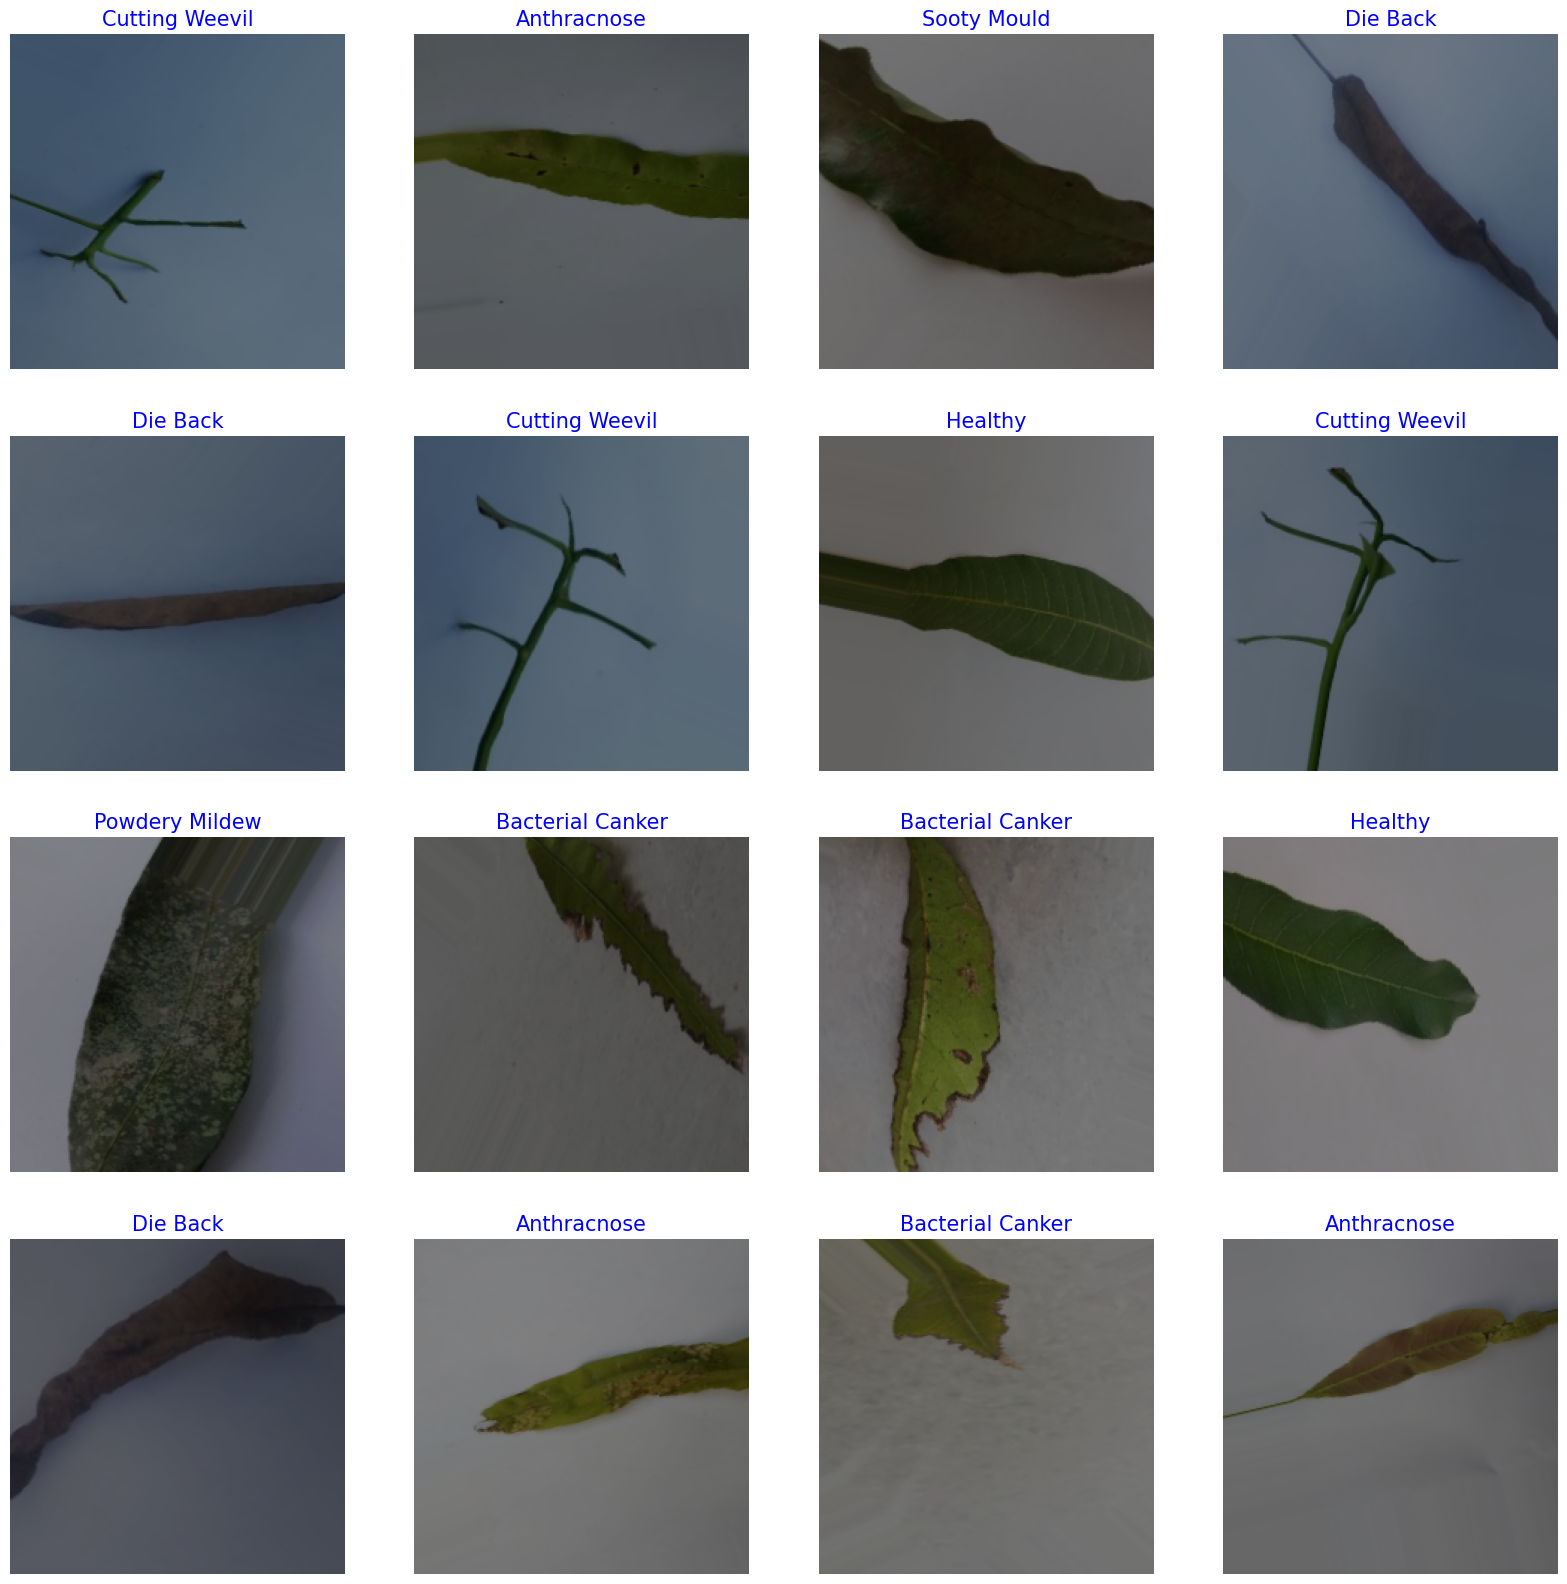

In [22]:
# Eğitim veri üreticisinin sınıf indislerini içeren bir sözlük oluşturulur.
g_dict = train_gen.class_indices  

# Sınıf adlarını içeren bir liste oluşturulur.
classes = list(g_dict.keys())       

# Eğitim veri üretecinin bir grup örneğini alınır.
images, labels = next(train_gen)      

# 20x20 büyüklüğünde bir çizim figürü oluşturulur.
plt.figure(figsize=(20, 20))  

# 16 örnek için bir döngü başlatılır.
for i in range(16):
    
    # 4x4'lük bir alt-çizim oluşturulur.
    plt.subplot(4, 4, i + 1)  
    
    # Görüntü, 0 ile 255 arasında değerler içeren bir dizi olarak normalleştirilir.
    image = images[i] / 255       
   
    # Normalleştirilmiş görüntü, alt-çizimde gösterilir.
    plt.imshow(image)  
    
    # Etiket dizisindeki en büyük değerin (1'e karşılık gelen) indeksi alınır.
    index = np.argmax(labels[i])  
    
    # İndise karşılık gelen sınıf adı alınır.
    class_name = classes[index]   
    
    # Alt-çizimin başlığı, sınıf adı olarak ayarlanır ve mavi renkte gösterilir.
    plt.title(class_name, color='blue', fontsize=15)  
    
    # Eksenler kapatılır, yani alt-çizimdeki koordinat ekseni gösterilmez.
    plt.axis('off')  
    
# Oluşturulan tüm alt-çizimleri içeren genel çizim gösterilir.
plt.show()  

In [23]:

# Model Yapısını Oluştur

# Giriş görüntü boyutları
img_size = (224, 224)

# Görüntü kanal sayısı (RGB için 3)
channels = 3

# Giriş görüntü şekli
img_shape = (img_size[0], img_size[1], channels)

# Modelin çıktı sınıf sayısını belirlemek için eğitim veri üreticisinin sınıf sayısı
class_count = len(list(train_gen.class_indices.keys()))

#EfficientNetB7 modeli yapılandırılır.
base_model = tf.keras.applications.efficientnet.EfficientNetB7(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')

# Önceden eğitilmiş modelin eğitilebilirliğini kapatma
base_model.trainable = False

# Yeni modelin oluşturulması
model = Sequential([
    base_model,  # Önceden eğitilmiş model
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),  # Batch normalization katmanı
    Dense(128, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),  # Yoğun (Dense) katman
    Dropout(rate=0.45, seed=123),   # Dropout katmanı
    Dense(class_count, activation='softmax')  # Çıkış katmanı
])

# Modelin derlenmesi
model.compile(Adamax(learning_rate=0.002), loss='categorical_crossentropy', metrics=['accuracy'])

# Modelin özetini görüntüleme
model.summary()



258076736/258076736 [==============================] - 149s 1us/step

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional  (None, 2560)              64097687  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 2560)              10240     
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 128)               327808    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 1032      
                                                  

In [24]:
from keras.utils import plot_model
plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [25]:
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5, 
                               restore_best_weights=True,
                               mode='min',
                              )

In [ ]:
batch_size = 16   # Eğitim için toplu boyutu ayarla(set batch size for training)
epochs = 50   # Eğitimdeki Toplam Epoch Sayısı

history = model.fit(x=train_gen,
                    epochs = epochs,
                    verbose = 1,
                    validation_data = valid_gen, 
                    validation_steps = None,
                    shuffle = False,
                    batch_size = batch_size,
                    callbacks = [early_stopping])

In [ ]:
# Gerekli Değişkenleri Tanımla
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Eğitim Geçmişini Çiz (Plot training history)

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss(Eğitim Kaybı): ", train_score[0])
print("Train Accuary(Eğitim Doğruluğu): ", train_score[1])
print('-' * 20)
print("Doğrulama Kaybı(Validation Loss): ", valid_score[0])
print("Doğrulama Başarısı(Validation Accuracy): ", valid_score[1])
print('-' * 20)
print("Test Kaybı(Test Loss): ", test_score[0])
print("Test Başarısı(Test Accuracy): ", test_score[1])

In [ ]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Karışıklık Matrisi
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('Gerçek Etiket')
plt.xlabel('Tahmini Etiket')

plt.show()

In [ ]:
# Sınıflandırma Raporu
print(classification_report(test_gen.classes, y_pred, target_names= classes))

In [ ]:
model.save_weights('my_model_weights.h5')

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

def predict_and_display(image_path, model, class_labels):
    
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    
    predicted_class_label = class_labels[predicted_class_index]
    
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted Vehicle: {predicted_class_label}")
    plt.show()

# Eğitilmiş modeli yüklüyoruz.
model.load_weights('/kaggle/working/my_model_weights.h5')

# Sınıf etiketlerini tanımlıyoruz
class_labels = list(train_gen.class_indices.keys())


image_path_to_test = '/kaggle/input/mango-leaf-disease-dataset/Anthracnose/20211008_124253 (Custom).jpg'
predict_and_display(image_path_to_test, model, class_labels)

In [ ]:
image_path_to_test = '/kaggle/input/mango-leaf-disease-dataset/Bacterial Canker/IMG_20211106_120951 (Custom).jpg'
predict_and_display(image_path_to_test, model, class_labels)

In [ ]:
image_path_to_test = '/kaggle/input/mango-leaf-disease-dataset/Cutting Weevil/20211011_160708 (Custom) (Custom).jpg'
predict_and_display(image_path_to_test, model, class_labels)